#Loading dependencies

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import skimage
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



#Loading dataset

In [ ]:
id = 22101916

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train, y_train = sklearn.utils.resample(x_train, y_train, replace = False, n_samples = 5000, random_state = id, stratify = y_train)
x_test, y_test = sklearn.utils.resample(x_test, y_test, replace = False, n_samples = 1000, random_state = id, stratify = y_train)

#Task 1: Training a logistic regressor [10 Marks]

###1. Convert the images to grayscale

In [ ]:
def rgb_to_grayscale(rgb_images):
    return np.dot(rgb_images[...,:3], [0.299, 0.587, 0.114])

x_train_gray = rgb_to_grayscale(x_train)
x_test_gray = rgb_to_grayscale(x_test)

print(f"Original RGB shape: {x_train.shape}")
print(f"Grayscale shape: {x_train_gray.shape}")

Original RGB shape: (5000, 32, 32, 3)
Grayscale shape: (5000, 32, 32)


### 2. Prepare the grayscale images for logistic regressor (reshape and normalize)

Use z-score normalization.

In [ ]:

x_train_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_flat = x_test_gray.reshape(x_test_gray.shape[0], -1)
mean = np.mean(x_train_flat)
std = np.std(x_train_flat)

x_train_normalized = (x_train_flat - mean) / std
x_test_normalized = (x_test_flat - mean) / std
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print(f"Training data shape after reshaping: {x_train_normalized.shape}")
print(f"Test data shape after reshaping: {x_test_normalized.shape}")
print(f"Training labels shape: {y_train_flat.shape}")
print(f"Data mean: {mean:.4f}, std: {std:.4f}")

Training data shape after reshaping: (5000, 1024)
Test data shape after reshaping: (1000, 1024)
Training labels shape: (5000,)
Data mean: 123.0976, std: 61.1881


###3. Create a validation set (20%)

In [ ]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train_normalized, y_train_flat,
    test_size=0.2,
    random_state=id,
    stratify=y_train_flat
)
print(f"Training set size: {x_train_split.shape[0]}")
print(f"Validation set size: {x_val_split.shape[0]}")
print(f"Test set size: {x_test_normalized.shape[0]}")

Training set size: 4000
Validation set size: 1000
Test set size: 1000


###4. Compute class weights

Go through this link - https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_split),
    y=y_train_split
)

class_weight_dict = dict(zip(np.unique(y_train_split), class_weights))

print("Class weights:", class_weight_dict)

unique, counts = np.unique(y_train_split, return_counts=True)
print("Class distribution in training set:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

Class weights: {np.uint8(0): np.float64(1.0), np.uint8(1): np.float64(1.0), np.uint8(2): np.float64(1.0), np.uint8(3): np.float64(1.0), np.uint8(4): np.float64(1.0), np.uint8(5): np.float64(1.0), np.uint8(6): np.float64(1.0), np.uint8(7): np.float64(1.0), np.uint8(8): np.float64(1.0), np.uint8(9): np.float64(1.0)}
Class distribution in training set:
Class 0: 400 samples
Class 1: 400 samples
Class 2: 400 samples
Class 3: 400 samples
Class 4: 400 samples
Class 5: 400 samples
Class 6: 400 samples
Class 7: 400 samples
Class 8: 400 samples
Class 9: 400 samples


###5. Run the logistic regressor

Use L2 regularizer. Find the C hyperparameter value through grid search. Pick the testing values according to your understanding. Use at least 3 test values and at max 5. Use the computed class weights while training your model.

In [ ]:

param_grid = {'C': [0.1, 1.0, 10.0, 100.0]}

logistic_model = LogisticRegression(
    penalty='l2',
    class_weight=class_weight_dict,
    random_state=id,
    max_iter=1000,
    solver='lbfgs' )

grid_search = GridSearchCV(
    logistic_model,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Performing grid search for optimal C value...")
grid_search.fit(x_train_split, y_train_split)

print(f"Best C value: {grid_search.best_params_['C']}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_logistic_model = grid_search.best_estimator_
val_predictions = best_logistic_model.predict(x_val_split)
val_accuracy = accuracy_score(y_val_split, val_predictions)
print(f"Validation accuracy: {val_accuracy:.4f}")

Performing grid search for optimal C value...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best C value: 0.1
Best cross-validation score: 0.2102
Validation accuracy: 0.2200


###6. Evaluate the logistic regressor on the test set

In [ ]:
test_predictions = best_logistic_model.predict(x_test_normalized)
test_accuracy = accuracy_score(y_test_flat, test_predictions)

print(f"Test accuracy: {test_accuracy:.4f}")
print("\nDetailed classification report:")
print(classification_report(y_test_flat, test_predictions))

Test accuracy: 0.1970

Detailed classification report:
              precision    recall  f1-score   support

           0       0.18      0.21      0.19        90
           1       0.20      0.20      0.20        90
           2       0.20      0.17      0.18       106
           3       0.16      0.16      0.16       100
           4       0.11      0.13      0.12       103
           5       0.16      0.15      0.16       107
           6       0.20      0.17      0.18       102
           7       0.19      0.20      0.20       106
           8       0.24      0.24      0.24        98
           9       0.32      0.36      0.34        98

    accuracy                           0.20      1000
   macro avg       0.20      0.20      0.20      1000
weighted avg       0.20      0.20      0.20      1000



###7. Write code to pick up a random image from the test set and display it

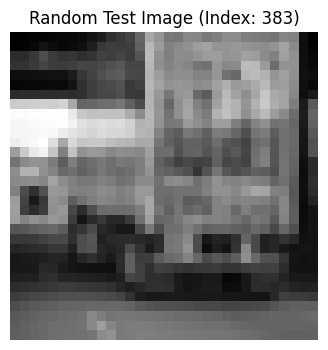

Selected image index: 383
True label: 9


In [ ]:

random_idx = random.randint(0, len(x_test_gray) - 1)
random_image = x_test_gray[random_idx]
random_label = y_test_flat[random_idx]
plt.figure(figsize=(6, 4))
plt.imshow(random_image, cmap='gray')
plt.title(f'Random Test Image (Index: {random_idx})')
plt.axis('off')
plt.show()

print(f"Selected image index: {random_idx}")
print(f"True label: {random_label}")

###8. Print the predicted class vs the original class

Do not print out the numerical class. Map it from here - https://keras.io/2/api/datasets/cifar10/

In [ ]:
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

random_image_normalized = x_test_normalized[random_idx].reshape(1, -1)
predicted_label = best_logistic_model.predict(random_image_normalized)[0]

print(f"Original class: {cifar10_classes[random_label]}")
print(f"Predicted class: {cifar10_classes[predicted_label]}")
print(f"Prediction correct: {random_label == predicted_label}")

Original class: truck
Predicted class: dog
Prediction correct: False


#Task 2: Training a convolutional neural network [20 Marks]

We will not strictly control how you implement this code. You can use either Tensorflow or PyTorch. However the structure of the network must be -

```
Input -> Conv1 -> Conv2 -> Conv3 -> Fully Connected 1 -> Fully Connected 2 -> Output
```

Use activation functions and pooling as you want. Feel free to adjust dimensions as you need. Set the hyperparameters yourself. Use a maximum learning rate of 0.01 and a maximum epoch number of 100. Use AdamW as optimizer.

**Try achieving good accuracy. There are marks for that.**

###1. Train the model on grayscale images

You do not need to use the validation set. Train on the initial train set. Recalculate the class weights again and pass it to the optimizer function. Normalize the images before processing.

In [ ]:
x_trainG = skimage.color.rgb2gray(x_train)
x_testG = skimage.color.rgb2gray(x_test)
class Classifier(nn.Module):
  def __init__(self, c_in=1, output_dim=10):
    super().__init__()
    self.layer1 = nn.Conv2d(c_in, 16, kernel_size=3, padding = 1)
    self.pool1  = nn.MaxPool2d(2, 2)
    self.layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool2  = nn.MaxPool2d(2, 2)
    self.layer3 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
    self.pool3  = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(1024, 128)


    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128, output_dim)

  def forward(self, x):
    x = self.pool1(F.relu(self.layer1(x)))
    x = self.pool2(F.relu(self.layer2(x)))
    x = self.pool3(F.relu(self.layer3(x)))

    x = torch.flatten(x, start_dim=1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)

    x = self.fc2(x)
    return x

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
x_trainG = torch.tensor(x_trainG, dtype=torch.float32, device=device)
y_train  = torch.tensor(y_train.squeeze(), dtype=torch.long, device=device)
x_testG  = torch.tensor(x_testG, dtype=torch.float32, device=device)
y_test   = torch.tensor(y_test.squeeze(), dtype=torch.long, device=device)
x_trainG = x_trainG.unsqueeze(1)
x_testG = x_testG.unsqueeze(1)



In [ ]:
mean = x_trainG.mean()
std = x_trainG.std()
x_trainG = (x_trainG - mean) / std
x_testG  = (x_testG - mean) / std


batch_size = 64
train_dataset = TensorDataset(x_trainG, y_train)
test_dataset  = TensorDataset(x_testG, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


epochs = 60
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:

        outputs = model(inputs)
        loss = criterion(outputs, labels)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_loss += loss.item() * inputs.size(0)
        zx, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = correct / total

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Loss: {epoch_loss:.4f} - "
          f"Acc: {epoch_acc:.4f}")


Epoch [1/60] - Loss: 2.1338 - Acc: 0.2118
Epoch [2/60] - Loss: 1.8432 - Acc: 0.3272
Epoch [3/60] - Loss: 1.6768 - Acc: 0.3946
Epoch [4/60] - Loss: 1.5525 - Acc: 0.4380
Epoch [5/60] - Loss: 1.4565 - Acc: 0.4692
Epoch [6/60] - Loss: 1.3837 - Acc: 0.5030
Epoch [7/60] - Loss: 1.2875 - Acc: 0.5386
Epoch [8/60] - Loss: 1.1973 - Acc: 0.5698
Epoch [9/60] - Loss: 1.1328 - Acc: 0.5968
Epoch [10/60] - Loss: 1.0365 - Acc: 0.6328
Epoch [11/60] - Loss: 0.9784 - Acc: 0.6512
Epoch [12/60] - Loss: 0.8841 - Acc: 0.6838
Epoch [13/60] - Loss: 0.8136 - Acc: 0.7148
Epoch [14/60] - Loss: 0.7371 - Acc: 0.7376
Epoch [15/60] - Loss: 0.6796 - Acc: 0.7590
Epoch [16/60] - Loss: 0.6435 - Acc: 0.7762
Epoch [17/60] - Loss: 0.5609 - Acc: 0.8032
Epoch [18/60] - Loss: 0.4987 - Acc: 0.8242
Epoch [19/60] - Loss: 0.4606 - Acc: 0.8416
Epoch [20/60] - Loss: 0.3865 - Acc: 0.8686
Epoch [21/60] - Loss: 0.3700 - Acc: 0.8758
Epoch [22/60] - Loss: 0.3229 - Acc: 0.8842
Epoch [23/60] - Loss: 0.3087 - Acc: 0.8950
Epoch [24/60] - Loss

###2. Evaluate the model on the grayscale test set


Test Accuracy: 0.5430


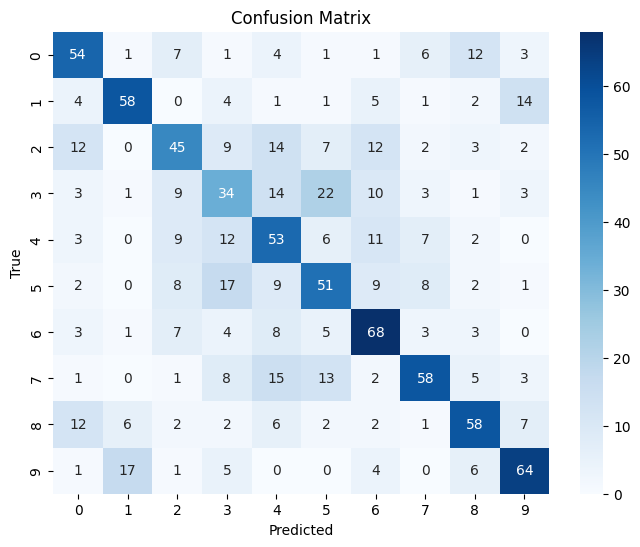


Classification Report of grey scale image:
              precision    recall  f1-score   support

           0     0.5684    0.6000    0.5838        90
           1     0.6905    0.6444    0.6667        90
           2     0.5056    0.4245    0.4615       106
           3     0.3542    0.3400    0.3469       100
           4     0.4274    0.5146    0.4670       103
           5     0.4722    0.4766    0.4744       107
           6     0.5484    0.6667    0.6018       102
           7     0.6517    0.5472    0.5949       106
           8     0.6170    0.5918    0.6042        98
           9     0.6598    0.6531    0.6564        98

    accuracy                         0.5430      1000
   macro avg     0.5495    0.5459    0.5458      1000
weighted avg     0.5470    0.5430    0.5430      1000



In [ ]:

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        ax1, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nTest Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print("\nClassification Report of grey scale image:")
print(classification_report(all_labels, all_preds, digits=4))



###3. Write code to pick up a random image from the test set and display it

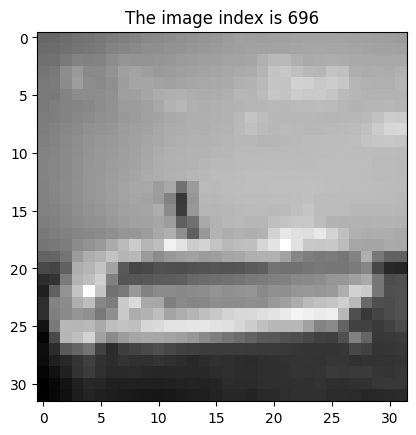

In [ ]:

random_image = random.randint(0, len(x_test) - 1)
x_testGrey = skimage.color.rgb2gray(x_test)
plt.imshow(x_testGrey[random_image], cmap='gray')
plt.title(f"The image index is {random_image}")
plt.show()

###4. Print the predicted class vs the original class

In [ ]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
true_class = class_names[y_test[random_image].item()]

model.eval()
with torch.no_grad():
    input_image = x_testG[random_image].unsqueeze(0)
    outputs = model(input_image)
    ax2, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"True class: {true_class}")
print(f"Predicted class (Grayscale model): {predicted_class}")

True class: ship
Predicted class (Grayscale model): ship


###5. Train the model on the RGB images

Keep the model same.

In [ ]:
class ClassifierRGB(nn.Module):
  def __init__(self, c_in=3, output_dim=10):
    super().__init__()
    self.layer1 = nn.Conv2d(c_in, 16, kernel_size=3, padding = 1)
    self.pool1  = nn.MaxPool2d(2, 2)
    self.layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool2  = nn.MaxPool2d(2, 2)
    self.layer3 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
    self.pool3  = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(1024, 128)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128, output_dim)

  def forward(self, x):
    x = self.pool1(F.relu(self.layer1(x)))
    x = self.pool2(F.relu(self.layer2(x)))
    x = self.pool3(F.relu(self.layer3(x)))

    x = torch.flatten(x, start_dim=1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)

    x = self.fc2(x)
    return x

In [ ]:
mean = x_train.mean()
std = x_train.std()
x_trainN = (x_train - mean) / std
x_testN  = (x_test - mean) / std


In [ ]:

x_train_rgb = torch.tensor(x_trainN, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
x_test_rgb  = torch.tensor(x_testN, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
y_train     = torch.tensor(y_train.squeeze(), dtype=torch.long, device=device)
y_test      = torch.tensor(y_test.squeeze(), dtype=torch.long, device=device)


batch_size = 64
train_dataset = TensorDataset(x_train_rgb, y_train)
test_dataset  = TensorDataset(x_test_rgb, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

modelRGB = ClassifierRGB(c_in=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRGB.parameters(), lr=1e-3)
epochs = 60
for epoch in range(epochs):
    modelRGB.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        outputs = modelRGB(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        zx, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = correct / total

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Loss: {epoch_loss:.4f} - "
          f"Acc: {epoch_acc:.4f}")


/tmp/ipython-input-3976977915.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train     = torch.tensor(y_train.squeeze(), dtype=torch.long, device=device)
/tmp/ipython-input-3976977915.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test      = torch.tensor(y_test.squeeze(), dtype=torch.long, device=device)


Epoch [1/60] - Loss: 2.0576 - Acc: 0.2352
Epoch [2/60] - Loss: 1.7517 - Acc: 0.3578
Epoch [3/60] - Loss: 1.5866 - Acc: 0.4214
Epoch [4/60] - Loss: 1.4722 - Acc: 0.4692
Epoch [5/60] - Loss: 1.3929 - Acc: 0.5004
Epoch [6/60] - Loss: 1.3094 - Acc: 0.5288
Epoch [7/60] - Loss: 1.2420 - Acc: 0.5504
Epoch [8/60] - Loss: 1.1807 - Acc: 0.5718
Epoch [9/60] - Loss: 1.1324 - Acc: 0.5928
Epoch [10/60] - Loss: 1.0642 - Acc: 0.6134
Epoch [11/60] - Loss: 0.9969 - Acc: 0.6426
Epoch [12/60] - Loss: 0.9338 - Acc: 0.6662
Epoch [13/60] - Loss: 0.8742 - Acc: 0.6916
Epoch [14/60] - Loss: 0.8056 - Acc: 0.7084
Epoch [15/60] - Loss: 0.7490 - Acc: 0.7288
Epoch [16/60] - Loss: 0.7042 - Acc: 0.7446
Epoch [17/60] - Loss: 0.6217 - Acc: 0.7840
Epoch [18/60] - Loss: 0.5576 - Acc: 0.8036
Epoch [19/60] - Loss: 0.5186 - Acc: 0.8184
Epoch [20/60] - Loss: 0.4505 - Acc: 0.8458
Epoch [21/60] - Loss: 0.4256 - Acc: 0.8524
Epoch [22/60] - Loss: 0.3917 - Acc: 0.8606
Epoch [23/60] - Loss: 0.3425 - Acc: 0.8816
Epoch [24/60] - Loss

###6. Evaluate the model on the RGB images


Test Accuracy: 0.5420


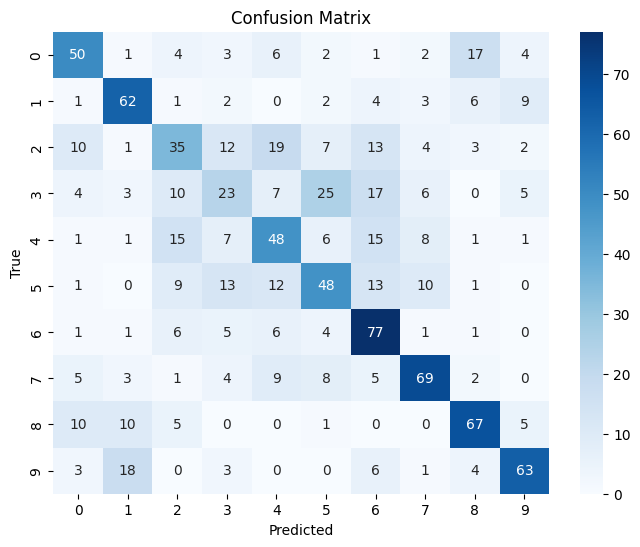


Classification Report of RGB image:
              precision    recall  f1-score   support

           0     0.5814    0.5556    0.5682        90
           1     0.6200    0.6889    0.6526        90
           2     0.4070    0.3302    0.3646       106
           3     0.3194    0.2300    0.2674       100
           4     0.4486    0.4660    0.4571       103
           5     0.4660    0.4486    0.4571       107
           6     0.5099    0.7549    0.6087       102
           7     0.6635    0.6509    0.6571       106
           8     0.6569    0.6837    0.6700        98
           9     0.7079    0.6429    0.6738        98

    accuracy                         0.5420      1000
   macro avg     0.5381    0.5452    0.5377      1000
weighted avg     0.5354    0.5420    0.5347      1000



In [ ]:
modelRGB.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = modelRGB(inputs)
        ax3, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nTest Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print("\nClassification Report of RGB image:")
print(classification_report(all_labels, all_preds, digits=4))

###7. Write code to pick up a random image from the test set and display it

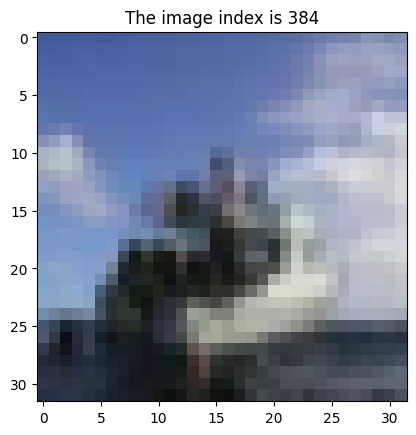

In [ ]:
random_imageRGB = random.randint(0, len(x_test) - 1)
plt.imshow(x_test[random_imageRGB])
plt.title(f"The image index is {random_imageRGB}")
plt.show()

###8. Print the predicted class vs the original class

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

true_class = class_names[y_test[random_imageRGB].item()]
modelRGB.eval()
with torch.no_grad():
    input_image = x_test_rgb[random_imageRGB].unsqueeze(0)
    outputs = modelRGB(input_image)
    ax4, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]

print(f"True class: {true_class}")
print(f"Predicted class (RGB model): {predicted_class}")

True class: ship
Predicted class (RGB model): airplane


###9. Add one more conv layer and check if it increases the performance for the RGB images

In [ ]:
class ClassifierRGBL(nn.Module):
  def __init__(self, c_in=3, output_dim=10):
    super().__init__()
    self.layer1 = nn.Conv2d(c_in, 16, kernel_size=3, padding = 1)
    self.pool1  = nn.MaxPool2d(2, 2)
    self.layer2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    self.pool2  = nn.MaxPool2d(2, 2)
    self.layer3 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
    self.pool3  = nn.MaxPool2d(2, 2)

    self.layer4 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
    self.pool4  = nn.MaxPool2d(2, 2)

    self.fc1 = nn.Linear(512, 128)
    self.dropout = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128, output_dim)

  def forward(self, x):
    x = self.pool1(F.relu(self.layer1(x)))
    x = self.pool2(F.relu(self.layer2(x)))
    x = self.pool3(F.relu(self.layer3(x)))
    x = self.pool4(F.relu(self.layer4(x)))

    x = torch.flatten(x, start_dim=1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)

    x = self.fc2(x)
    return x

In [ ]:
mean = x_train.mean()
std = x_train.std()
x_trainE = (x_train - mean) / std
x_testE  = (x_test - mean) / std

/tmp/ipython-input-3147935641.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train     = torch.tensor(y_train.squeeze(), dtype=torch.long, device=device)
/tmp/ipython-input-3147935641.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test      = torch.tensor(y_test.squeeze(), dtype=torch.long, device=device)


Epoch [1/60] - Loss: 2.0887 - Acc: 0.2080
Epoch [2/60] - Loss: 1.8124 - Acc: 0.3270
Epoch [3/60] - Loss: 1.6761 - Acc: 0.3718
Epoch [4/60] - Loss: 1.5726 - Acc: 0.4062
Epoch [5/60] - Loss: 1.4813 - Acc: 0.4512
Epoch [6/60] - Loss: 1.3982 - Acc: 0.4850
Epoch [7/60] - Loss: 1.3236 - Acc: 0.5128
Epoch [8/60] - Loss: 1.2424 - Acc: 0.5498
Epoch [9/60] - Loss: 1.1737 - Acc: 0.5678
Epoch [10/60] - Loss: 1.1132 - Acc: 0.5864
Epoch [11/60] - Loss: 1.0384 - Acc: 0.6174
Epoch [12/60] - Loss: 0.9690 - Acc: 0.6446
Epoch [13/60] - Loss: 0.9323 - Acc: 0.6622
Epoch [14/60] - Loss: 0.8166 - Acc: 0.6994
Epoch [15/60] - Loss: 0.7367 - Acc: 0.7306
Epoch [16/60] - Loss: 0.6707 - Acc: 0.7526
Epoch [17/60] - Loss: 0.6015 - Acc: 0.7832
Epoch [18/60] - Loss: 0.5226 - Acc: 0.8102
Epoch [19/60] - Loss: 0.4439 - Acc: 0.8408
Epoch [20/60] - Loss: 0.4509 - Acc: 0.8342
Epoch [21/60] - Loss: 0.3484 - Acc: 0.8756
Epoch [22/60] - Loss: 0.2943 - Acc: 0.8976
Epoch [23/60] - Loss: 0.2266 - Acc: 0.9242
Epoch [24/60] - Loss

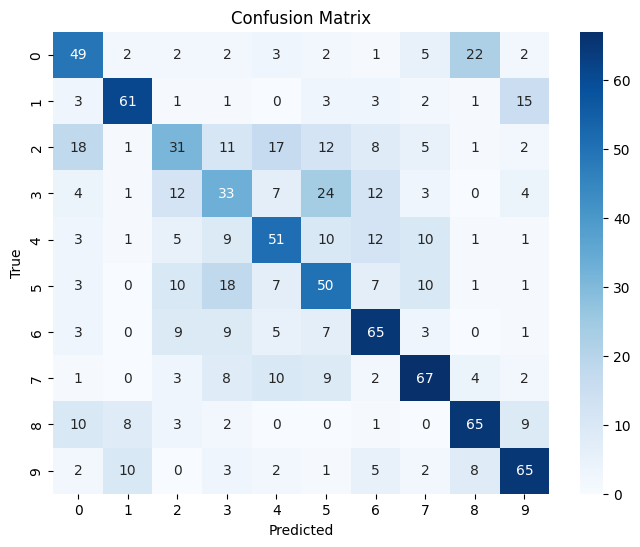


Classification Report of RGB image:
              precision    recall  f1-score   support

           0     0.5104    0.5444    0.5269        90
           1     0.7262    0.6778    0.7011        90
           2     0.4079    0.2925    0.3407       106
           3     0.3438    0.3300    0.3367       100
           4     0.5000    0.4951    0.4976       103
           5     0.4237    0.4673    0.4444       107
           6     0.5603    0.6373    0.5963       102
           7     0.6262    0.6321    0.6291       106
           8     0.6311    0.6633    0.6468        98
           9     0.6373    0.6633    0.6500        98

    accuracy                         0.5370      1000
   macro avg     0.5367    0.5403    0.5370      1000
weighted avg     0.5336    0.5370    0.5337      1000



In [ ]:

x_train_rgb = torch.tensor(x_trainE, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
x_test_rgb  = torch.tensor(x_testE, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
y_train     = torch.tensor(y_train.squeeze(), dtype=torch.long, device=device)
y_test      = torch.tensor(y_test.squeeze(), dtype=torch.long, device=device)
batch_size = 64
train_dataset = TensorDataset(x_train_rgb, y_train)
test_dataset  = TensorDataset(x_test_rgb, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
modelRGBL = ClassifierRGBL(c_in=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modelRGBL.parameters(), lr=1e-3)

epochs = 60
for epoch in range(epochs):
    modelRGBL.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        outputs = modelRGBL(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        ax5, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = correct / total

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Loss: {epoch_loss:.4f} - "
          f"Acc: {epoch_acc:.4f}")

modelRGBL.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = modelRGBL(inputs)
        ax6, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
test_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"\nTest Accuracy: {test_acc:.4f}")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print("\nClassification Report of RGB image:")
print(classification_report(all_labels, all_preds, digits=4))



###10. Use the next markup to write down your observations and reasonings on the performances of the models

Observations -

Logistic regressor: The cifar10 is a very noisy dataset. Also the data is very complex to learn Logistic regressor.

Grey Scale CNN: We got a better result after applying CNN. Grey scale reduces the actual channels and stll giving low accuracy.

RGB CNN: RGB input channels demonstrated accuracy improvements, yet the model's performance stagnated due to noisy dataset limitations.

RGB CNN with extra conv: We expected to increase accuracy after increasing a convolution layer. But it decreased. Vanishing gradient, overfitting and optimization difficulty could be reasons of reducing accuracy.